In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [2]:
descriptive_prompt_8 =  "Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Tell me how many residues are in the chains and beta sheets. 3. Simulate for 1 ps at 300 K. 4. Compute the RMSD of the simulation at 300 K. 5. Compute the radius of gyration over time for the simulation at 300 K. 6. Simulate for 1 ps at 400 K. 7. Compute the RMSD of the simulation at 400 K. 8. Compute the radius of gyration over time for the simulation at 400 K."
non_descriptive_prompt_8 = "Simulate 1LYZ for 1 ps at 300K and 400K. Tell me how many residues are in the chains and beta sheets, and compute the RMSD and radius of gyration of both simulations."

Required Tasks:
- Download
- SS Analysis
- Simulation_1
- RMSD_1
- Rgy_1
- Simulation_2
- RMSD_2
- Rgy_2

In [3]:
llm_model = "claude-3-opus-20240229"
tools = "all"

In [4]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools)
agent_1.run(descriptive_prompt_8)

Thought: To complete the tasks, I will first download the PDB file for 1LYZ. Then I will analyze the structure to determine the number of residues in the chains and beta sheets. Next, I will set up and run two short simulations at 300K and 400K. For each simulation, I will compute the RMSD and radius of gyration over time. I will use the provided tools to accomplish each step.

Action:
```
{
  "action": "PDBFileDownloader",
  "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Here are the next steps to continue the analysis:

Thought: Now that I have downloaded the PDB file for 1LYZ, I will analyze the structure to determine the number of residues in the chains and beta sheets using the GetTurnsBetaSheetsHelices tool.

Action:
```
{
  "action": "GetTurnsBetaSheetsHelices",
  "action_input": {
    "query": "1LYZ", 
    "primary_accession": "P00720"
  }
}
```

The primary accession number provided does not match any entry in the data, using the first entry instead.
The prima

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

In [7]:
registry = agent_1.path_registry
print(registry.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_233311: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_233311
 rec0_233327: dssp values for trajectory with id: 1LYZ_233311
 1LYZ_233353: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_233409: Initial positions for simulation sim0_233409
 sim0_233409: Basic Simulation of Protein 1LYZ_233353
 rec0_233413: Simulation trajectory for protein 1LYZ_233353 and simulation sim0_233409
 rec1_233413: Simulation state log for protein 1LYZ_233353 and simulation sim0_233409
 rec2_233413: Simulation pdb frames for protein 1LYZ_233353 and simulation sim0_233409
 rmsd_1LYZ: RMSD for 1LYZ
 fig0_233852: RMSD plot for 1LYZ
 rgy_rec0_233413: Radii of gyration per frame for rec0_233413
 top_sim0_233914: Initial positions for simulation sim0_233914
 sim0_233914: Basic Simulation of Protein 1LYZ_233353
 rec0_233918: Simulation trajectory for protein

In [15]:
traj_path_1 = registry.get_mapped_path("rec0_233413")
top_path_1 = registry.get_mapped_path("top_sim0_233409")

assert os.path.exists(registry.get_mapped_path('1LYZ_233311'))
assert os.path.exists(traj_path_1)
assert os.path.exists(top_path_1)
assert os.path.exists(registry.get_mapped_path('rmsd_1LYZ'))
assert os.path.exists(registry.get_mapped_path('rgy_rec0_233413'))


traj_path_2 = registry.get_mapped_path("rec0_233918")
top_path_2 = registry.get_mapped_path("top_sim0_233914")

assert os.path.exists(traj_path_2)
assert os.path.exists(top_path_2)
assert os.path.exists(registry.get_mapped_path('rmsd_1LYZ_1'))
# assert os.path.exists(registry.get_mapped_path('rgy_path_2'))

In [19]:
from mdagent.tools.base_tools import ComputeDSSP

traj = md.load(traj_path_1, top=top_path_1)
traj = traj[-1]
#get dssp 
dssp = ComputeDSSP(registry)
dssp._summarize_dssp(dssp._compute_dssp(traj))

{'residues in helix': 51,
 'residues in strand': 14,
 'residues in coil': 64,
 'residues not assigned, not a protein residue': 6794}

In [20]:
from mdagent.tools.base_tools import ComputeDSSP

traj = md.load(traj_path_2, top=top_path_2)
traj = traj[-1]
#get dssp 
dssp = ComputeDSSP(registry)
dssp._summarize_dssp(dssp._compute_dssp(traj))

{'residues in helix': 55,
 'residues in strand': 16,
 'residues in coil': 58,
 'residues not assigned, not a protein residue': 6794}

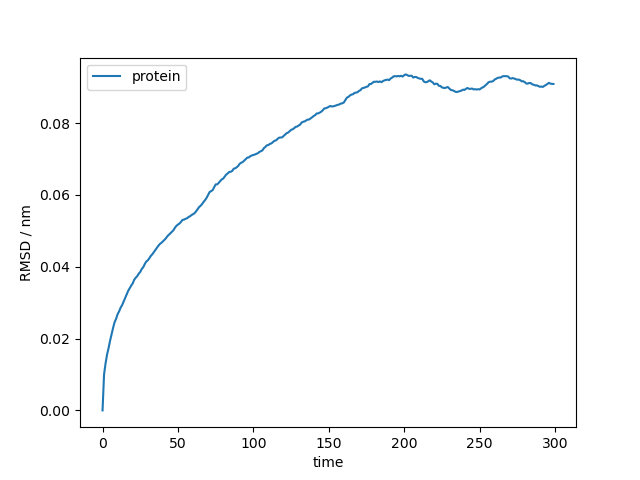

In [22]:
#plot rmsd
from IPython.display import Image
Image(filename=registry.get_mapped_path('fig0_233852'))

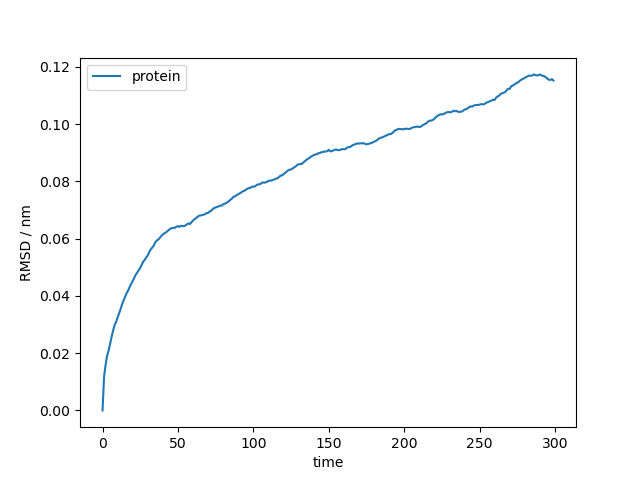

In [23]:
#plot rmsd
from IPython.display import Image
Image(filename=registry.get_mapped_path('fig0_234711'))

In [24]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools)
agent_2.run(non_descriptive_prompt_8)

Thought: To simulate 1LYZ at two different temperatures and analyze the results, I will first need to download the PDB file. Then I can set up and run short simulations at 300K and 400K. After that, I can analyze the trajectories to get the requested information about residues, beta sheets, RMSD, and radius of gyration.

Action:
```
{
  "action": "PDBFileDownloader",
  "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Here are the next steps to continue the simulation and analysis:

Thought: Now that I have the PDB file for 1LYZ, I can set up and run a short 1 ps simulation at 300K. I'll use the SetUpandRunFunction tool to do this.

Action:
```
{
  "action": "SetUpandRunFunction",
  "action_input": {
    "pdb_id": "1LYZ_235515",
    "forcefield_files": ["amber14/protein.ff14SB.xml", "amber14/tip3p.xml"],
    "save": true,
    "system_params": {
      "nonbondedMethod": "PME", 
      "nonbondedCutoff": 1.0,
      "constraints": "HBonds",
      "rigidWater": true,
      "co

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

In [36]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_235515: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_235515
 1LYZ_235541: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_235556: Initial positions for simulation sim0_235556
 sim0_235556: Basic Simulation of Protein 1LYZ_235541
 rec0_235604: Simulation trajectory for protein 1LYZ_235541 and simulation sim0_235556
 rec1_235604: Simulation state log for protein 1LYZ_235541 and simulation sim0_235556
 rec2_235604: Simulation pdb frames for protein 1LYZ_235541 and simulation sim0_235556
 top_sim0_063329: Initial positions for simulation sim0_063329
 sim0_063329: Basic Simulation of Protein 1LYZ_235541
 rec0_063335: Simulation trajectory for protein 1LYZ_235541 and simulation sim0_063329
 rec1_063335: Simulation state log for protein 1LYZ_235541 and simulation sim0_063329
 rec2_063335: Simulation pdb frames for protein 1LYZ_2355

In [38]:
traj_path_1 = registry_2.get_mapped_path("rec0_235604")
top_path_1 = registry_2.get_mapped_path("top_sim0_235556")

assert os.path.exists(registry_2.get_mapped_path('1LYZ_235541'))
assert os.path.exists(traj_path_1)
assert os.path.exists(top_path_1)
assert os.path.exists(registry_2.get_mapped_path('rmsd_1LYZ 300K'))
# assert os.path.exists(registry_2.get_mapped_path('rgy_path_1'))


traj_path_2 = registry_2.get_mapped_path("rec0_063335")
top_path_2 = registry_2.get_mapped_path("top_sim0_063329")

assert os.path.exists(traj_path_2)
assert os.path.exists(top_path_2)
assert os.path.exists(registry_2.get_mapped_path('rmsd_1LYZ 400K'))
# assert os.path.exists(registry_2.get_mapped_path('rgy_path_2'))

In [41]:
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_2)
dssp._run(traj_file="rec0_235604", top_file="top_sim0_235556", target_frames="all")

"{'residues in helix': 5288, 'residues in strand': 1418, 'residues in coil': 6194, 'residues not assigned, not a protein residue': 679200}"

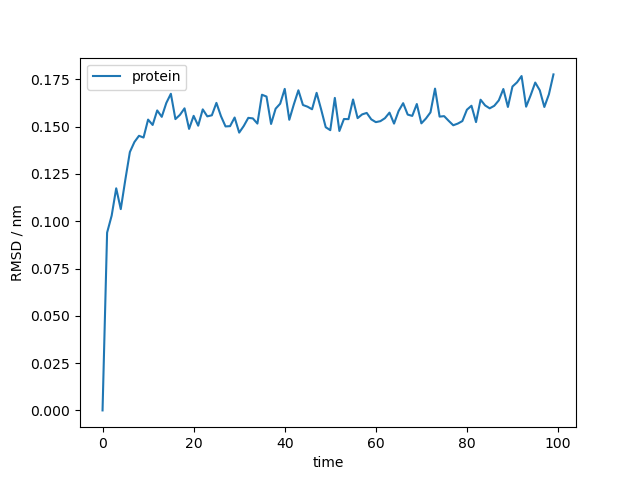

In [43]:
#plot rmsd
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_120649'))

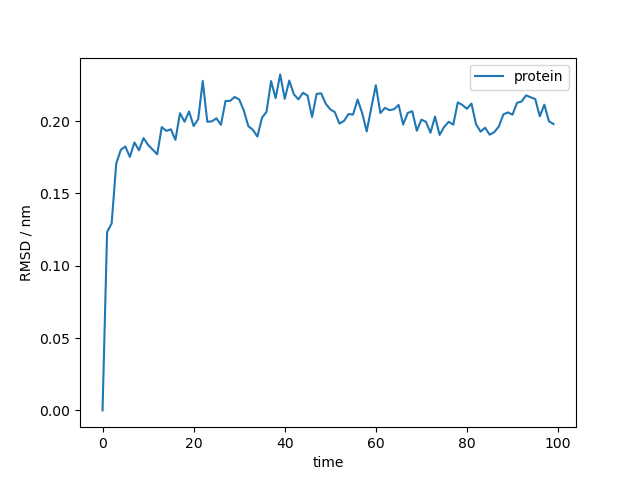

In [45]:
#plot rmsd
Image(filename=registry_2.get_mapped_path('fig0_120656'))